In [1]:
#!pip install -q -U torch sahi ultralytics
!pip install -q -U sahi ultralytics

In [2]:
%load_ext memory_profiler

In [3]:
import torch
import torchvision
from ultralytics import YOLO
import sys
import cv2
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [4]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117
CUDA is available: True


In [5]:
def yolov8_detection():

    model=YOLO('/home/robotica10/yolov8/runs/segment/train3/weights/best.pt')
    image = "/home/robotica10/yolov7-segmentation/c.v2i.yolov5pytorch/train/images/0b73d9f7-sample_1593_png.rf.ad781b3b3b8137dc9b703545bafe73f7.jpg"
    
    results = model(image, stream=True)  # generator of Results objects

    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs
    
    bbox=boxes.xyxy.tolist()[0]
    return bbox

In [6]:
image = cv2.imread("/home/robotica10/yolov7-segmentation/c.v2i.yolov5pytorch/train/images/0b73d9f7-sample_1593_png.rf.ad781b3b3b8137dc9b703545bafe73f7.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [7]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

In [8]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [9]:
yolov8_boxex=yolov8_detection()


image 1/1 /home/robotica10/yolov7-segmentation/c.v2i.yolov5pytorch/train/images/0b73d9f7-sample_1593_png.rf.ad781b3b3b8137dc9b703545bafe73f7.jpg: 256x256 1 mwds, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 220.4ms postprocess per image at shape (1, 3, 256, 256)


In [10]:
yolov8_boxex

[0.3231658935546875,
 0.3585968017578125,
 148.31199645996094,
 215.86033630371094]

In [11]:
input_box = np.array(yolov8_boxex)
input_label = np.array([1])

/home/robotica10/anaconda3/envs/yolosampaper/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/robotica10/anaconda3/envs/yolosampaper/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/robotica10/anaconda3/envs/yolosampaper/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/robotica10/anaconda3/envs/yolosampa

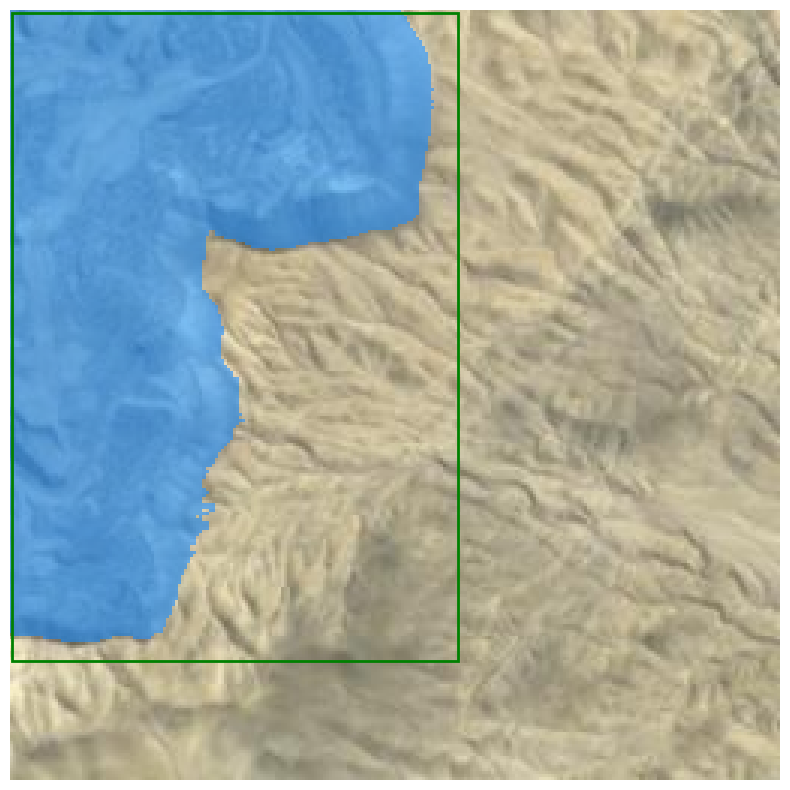

In [12]:
masks, _, _ = predictor.predict(
    point_coords=None,
    #point_labels=None,
    point_labels=input_label,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Visualizacion de mascaras predichas con YOLOv8

In [13]:
def random_label_path(label_folder):
    # Lista de archivos .txt en la carpeta de etiquetas
    labels = [f for f in os.listdir(label_folder) if f.endswith('.txt')]
    
    # Seleccionar un archivo de etiqueta al azar
    random_label_name = random.choice(labels)
    label_path = os.path.join(label_folder, random_label_name)

    return label_path

def show_image_and_mask(image_path, label_path):
    # Cargar imagen
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Leer y aplicar máscara
    with open(label_path, 'r') as file:
        mask_coords = [float(coord) for coord in file.read().split()[1:]]  # Ignorar el primer número (clase)
        mask = coords_to_mask(mask_coords, image_path)

    # Mostrar imagen y máscara
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Imagen')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Máscara')
    plt.axis('off')

    plt.show()

def coords_to_mask(coords, image_path):
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    mask = np.zeros((height, width), dtype=np.uint8)

    # Convertir coordenadas normalizadas en coordenadas de píxeles reales
    points = [(int(x * width), int(y * height)) for x, y in zip(coords[::2], coords[1::2])]
    points = np.array(points, dtype=np.int32).reshape((-1, 1, 2))

    # Dibujar la máscara
    cv2.fillPoly(mask, [points], 255)  # 255 para la máscara blanca

    return mask

def find_corresponding_image(label_path, image_folder):
    # Obtener el nombre del archivo de imagen correspondiente
    image_filename = os.path.basename(label_path).replace('.txt', '.png')
    image_path = os.path.join(image_folder, image_filename)

    return image_path

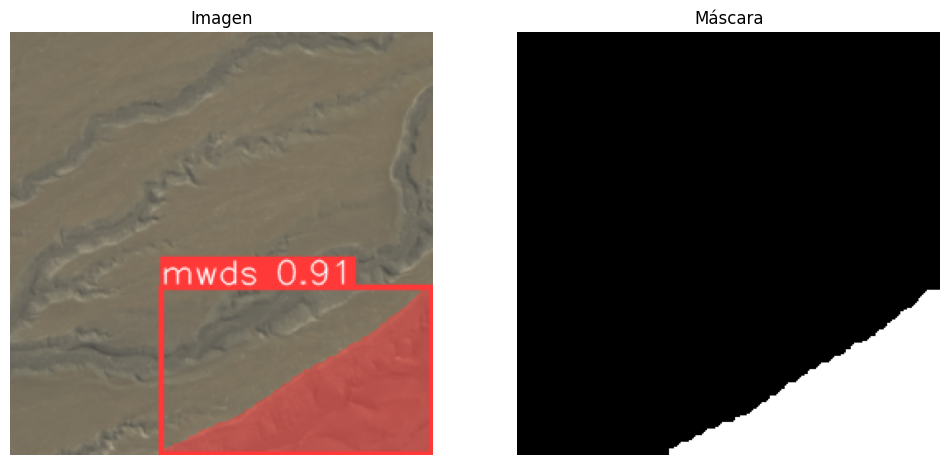

In [14]:
# Rutas a las carpetas de imágenes y etiquetas
image_folder = '/home/robotica10/yolov8/runs/segment/predict'
label_folder = os.path.join(image_folder, 'labels')

# Obtener un archivo de etiqueta al azar y la imagen correspondiente
label_path = random_label_path(label_folder)
image_path = find_corresponding_image(label_path, image_folder)

# Mostrar la imagen y su máscara
show_image_and_mask(image_path, label_path)


### Calculo de métricas:

In [15]:
def calculate_iou(mask1, mask2):
    # Intersección
    intersection = np.logical_and(mask1, mask2)
    
    # Unión
    union = np.logical_or(mask1, mask2)
    
    # Calcular IoU
    iou_score = np.sum(intersection) / np.sum(union)
    
    return iou_score

In [16]:
def load_coco_masks(json_file, image_id):
    """
    Carga las máscaras de segmentación para una imagen específica desde un archivo JSON en formato COCO.

    :param json_file: Ruta al archivo JSON en formato COCO.
    :param image_id: ID de la imagen para la cual se cargarán las máscaras.
    :return: Lista de máscaras binarias para la imagen especificada.
    """
    with open(json_file, 'r') as file:
        data = json.load(file)

    # Encontrar las dimensiones de la imagen
    for img in data['images']:
        if img['id'] == image_id:
            width, height = img['width'], img['height']
            break

    masks = []
    for ann in data['annotations']:
        if ann['image_id'] == image_id and not ann['iscrowd']:
            mask = np.zeros((height, width), dtype=np.uint8)
            for segment in ann['segmentation']:
                # Los segmentos pueden tener múltiples polígonos
                poly = np.array(segment).reshape((-1, 2))
                cv2.fillPoly(mask, [poly.astype(np.int32)], 255)  # 255 para la máscara blanca
            masks.append(mask)

    return masks


El IoU es: 0.0


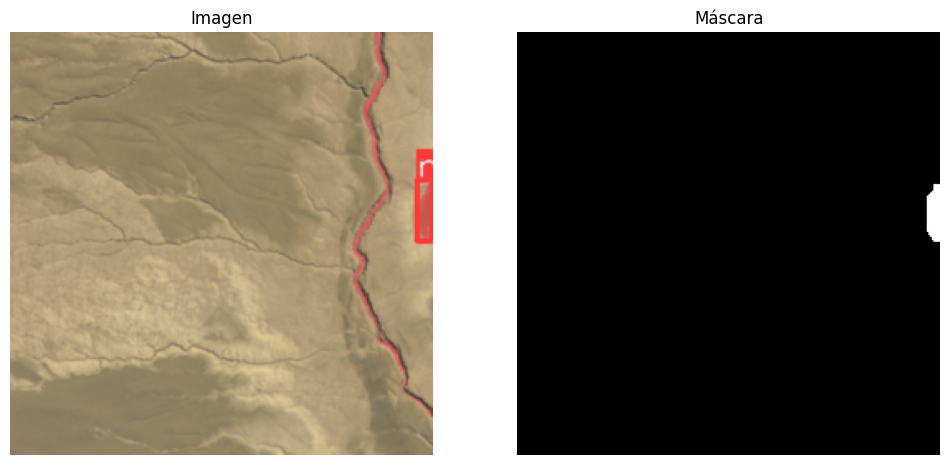

In [17]:
# Obtener un archivo de etiqueta al azar y la imagen correspondiente
label_path = random_label_path(label_folder)
image_path = find_corresponding_image(label_path, image_folder)

# Suponiendo que tienes una función que te da la máscara de verdad terrenal
# Por ejemplo: ground_truth_mask = get_ground_truth_mask(image_path)
# Esta función necesitarías implementarla según tus datos de verdad terrenal
# Como ejemplo, la inicializaremos con una matriz vacía
ground_truth_mask = np.zeros((256, 256), dtype=np.uint8)  # Reemplazar con la función real

# Obtener la máscara de predicción
with open(label_path, 'r') as file:
    mask_coords = [float(coord) for coord in file.read().split()[1:]]  # Ignorar el primer número (clase)
    predicted_mask = coords_to_mask(mask_coords, image_path)

# Calcular IoU
iou_score = calculate_iou(predicted_mask, ground_truth_mask)
print(f"El IoU es: {iou_score}")

# Opcional: Mostrar la imagen con su máscara de predicción
show_image_and_mask(image_path, label_path)

## Calculo IoU (arreglar)

In [18]:
import json
import os
import numpy as np
from PIL import Image, ImageDraw

def load_ground_truth_annotations(json_path):
    """ Carga las anotaciones de ground truth desde un archivo JSON en formato COCO. """
    with open(json_path) as f:
        data = json.load(f)

    annotations = {}
    for ann in data['annotations']:
        image_id = ann['image_id']
        segmentation = ann['segmentation'][0]  # Asume que hay una sola segmentación por objeto
        bbox = ann['bbox']

        # Convertir la segmentación a una máscara binaria
        mask = segmentation_to_mask(segmentation, bbox, data['images'][image_id]['width'], data['images'][image_id]['height'])
        annotations[data['images'][image_id]['file_name']] = mask

    return annotations

def segmentation_to_mask(segmentation, bbox, width, height):
    """ Convierte una segmentación en formato COCO a una máscara binaria. """
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(segmentation, outline=1, fill=1)
    return np.array(img)

def load_model_predictions(labels_folder, ground_truth):
    """ Carga las predicciones del modelo desde archivos de texto. 
        Se asume que el nombre del archivo de texto corresponde al nombre de archivo en las anotaciones de ground truth. """
    predictions = {}
    for filename in os.listdir(labels_folder):
        with open(os.path.join(labels_folder, filename)) as f:
            content = f.read().strip()

        # Obtener el ancho y el alto de la imagen correspondiente
        image_name = filename.replace('.txt', '.png')  # Asumiendo que los nombres de archivo coinciden
        if image_name in ground_truth:
            width, height = ground_truth[image_name].shape
            
            coords = [float(x) for x in content.split()]
            if len(coords) % 2 != 0:
                raise ValueError(f"Archivo {filename} tiene un número impar de coordenadas.")
            mask = coords_to_mask(coords, width, height)
            predictions[image_name] = mask

    return predictions

def coords_to_mask(coords, filename, width, height):
    """ Convierte coordenadas normalizadas a una máscara binaria. """
    # Escalar las coordenadas
    scaled_coords = [((x * width) if i % 2 == 0 else (x * height)) for i, x in enumerate(coords)]

    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(scaled_coords, outline=1, fill=1)
    return np.array(img)

def calculate_iou(mask1, mask2):
    """ Calcula el IoU entre dos máscaras binarias. """
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return np.sum(intersection) / np.sum(union)

# Rutas a los archivos y carpetas
json_path = '/home/robotica10/yolosampaper/project-5-at-2023-01-23-03-20-3039b793/result.json'
labels_folder = '/home/robotica10/yolov8/runs/segment/predict/labels'  # Actualiza esta ruta

# Cargar anotaciones y predicciones
ground_truth = load_ground_truth_annotations(json_path)
predictions = load_model_predictions(labels_folder, ground_truth)

# Calcular IoU para cada imagen
ious = {}
for image_name, gt_mask in ground_truth.items():
    pred_mask = predictions.get(image_name)
    if pred_mask is not None:
        iou = calculate_iou(gt_mask, pred_mask)
        ious[image_name] = iou

# Mostrar los resultados
for image_name, iou in ious.items():
    print(f"{image_name}: IoU = {iou}")
